# Results and validation


In this section the some results are shown by using the implemented class. The forward integration will be done by using the library function `scipy.integrate.solve_ivp()`, which will allow us to use all kinds of integrators (Runge-Kutta, Radau, ...).

Both imbibition and drying will be shown here. In order to allow comparison with the results found in {cite}`A4`, the same material - a kind of autoclaved aerated concrete (AAC) - is being used:

* free saturation: $w_{cap} = 350 \,kg/m^3$
* water vapor diffusion resistance factor: $\mu = 6$
* pore size: $r = 10^{-6} \,m$,
* free parameter: $n = 5$,
* water intake coefficient: $A = 6 \,kg / (m^2 \sqrt h)$

The shape of the specimen will be a cuboid a length of $0.1 \,m$ and a (normalized) section area of $1 \,m^2$.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib
import time

import one_d_problem_physics as opp


Setup matplotlib parameters for appropriately sized plots.

In [3]:
plt.rcParams["figure.figsize"] = (8,6)
font = {'size'   : 14}
matplotlib.rc('font', **font)

Global resolution (convenience for rendering)

In [ ]:
res_g = 160

## Overview

### Problem setup

In [4]:
my_problem = opp.one_d_problem(res=res_g, sim_time=48, material='AAC_A4_mod', init_w = 0, length=.1, w_west=1, w_east=0)

my_problem.fluid_flow_west = True
my_problem.fluid_flow_east = False
my_problem.vapour_flow_west = False
my_problem.vapour_flow_east = False

my_problem.liquid_conduction = True
my_problem.vapour_diffusion = True

w0 = my_problem.w[:]

t0 = 0  # Start time in hours
tf = my_problem.sim_time  # End time in hours

t_eval = np.linspace(t0, tf, 100)


### Solving

In [5]:
print('Calling scipy.integrate.sloveivp() ...')
start_time = time.time()
sol = solve_ivp(my_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method='Radau',
                vectorized=False, dense_output=False, atol=1e-7, rtol=1e-5)
print(f'time elapsed: {(time.time() - start_time):.3f} s')

Calling scipy.integrate.sloveivp() ...


G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:22: RuntimeWarning: overflow encountered in exp
  rh = np.exp(-p_suc / (rho_w * Rv * T_ref))
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:250: RuntimeWarning: invalid value encountered in multiply
  dwdt[-2] += self.delta_p / self.dx**2 * (p_vap[-1] - p_vap[-2]) * self.vapour_flow_east * self.vapour_diffusion


time elapsed: 10.248 s


### Plotting
The code below saves the animation to a file. Showing animated plots in a Jupyter Notebook turned out to be invonvenient, so it was decided to save it to a file and import a pre-calculated animation as a .gif file below.

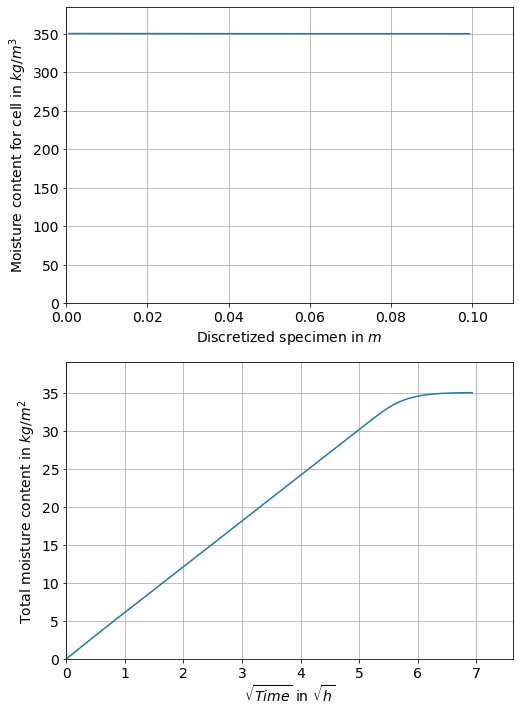

In [11]:
import matplotlib.animation as anim


anim_time = 8

font = {'size': 14}
matplotlib.rc('font', **font)

fig, axes = plt.subplots(nrows=2, figsize=(8, 12))

fps = 20
total_frames = sol.y.shape[1]
frame_freq = int(total_frames / (fps * anim_time)) + 1
display_frames = [i * frame_freq for i in range(fps*anim_time) if i*frame_freq < sol.y.shape[1]]
display_frames.append(sol.y.shape[1]-1)

# setup figures (axes objects)
axes[0].grid()
axes[0].axis([0, 1.1 * my_problem.length, 0, 1.1 * my_problem.free_saturation])
axes[0].set_xlabel('Discretized specimen in $m$')
axes[0].set_ylabel('Moisture content for cell in $kg/m^3$')

axes[1].grid()
axes[1].set_xlabel('$\sqrt{Time}$ in $\sqrt{h}$')
axes[1].set_ylabel('Total moisture content in $kg/m^2$')
axes[1].axis([0, 1.1 * np.sqrt(sol.t[-1]), 0, 1.1 * max(sum(sol.y[:, 0]), sum(sol.y[:, -1])) * my_problem.dx])


# initial states
line1, = axes[0].plot(my_problem.x, sol.y[1:-1,0])
t_sqrt_axis = np.sqrt(sol.t)
line2, = axes[1].plot([t_sqrt_axis[0]], [sum(sol.y[1:-1,0] * my_problem.dx)])

# animation function
def my_animation(i):
    line1.set_ydata(sol.y[1:-1, i])
    line2.set_xdata(t_sqrt_axis[:i+1])
    line2.set_ydata([sum(sol.y[1:-1,j]) * my_problem.dx for j in range(i+1)])

# create animation
ani = anim.FuncAnimation(fig, my_animation, frames=display_frames, interval=int(1000/fps))

# save to file
if True:
    writergif = anim.PillowWriter(fps=fps)
    ani.save('animation12.gif', writer=writergif)

### Results
Firstly, an animation of the imbibition experiment is being shown in {numref}`Figure {number} <animated_results-fig>`. On top, the profile of the specimen is shown as it takes water in from the left hand side. The phenomenon of the moving water front can be observed by noticing the steep part of the curve moving from left to right. On the bottom the total water content of the specimen over squareroot of time is displayed, as it would be done in an imbibition experiment.

```{figure} ./img/animated_results.gif
---
name: animated_results-fig
width: 600px
align: center
---
some caption
```

Next, we check the water intake coefficient, which would be a major result of the experiment.

In [18]:
def intake_coef(sol, dx, index):
    return (sol.y[1:-1, index+1].sum() - sol.y[1:-1, index].sum()) * dx / (np.sqrt(sol.t[index+1]) - np.sqrt(sol.t[index]))

intake_coef(sol, my_problem.dx, 3)

5.999241414682098

This is very close to the defined intake coefficient of $A = 6\,kg / (m^2 \sqrt h)$.

## Literature validation I: imbibition experiment
In an imbibition experiment a specimen is brought into contact with water on one side. The capillary forces will make the specimen transport water into its pores. This will be modeled by creating a constantly moisture saturated material cell on the one side of the specimen. The other side is assumed to be air- and water-tight.

### Problem setup

In [3]:
val_problem = opp.one_d_problem(res=res_g, sim_time=100, material='AAC_A4_mod', init_w=0, length=.1, w_west=1, w_east=0)
val_problem.fluid_flow_west = True
val_problem.fluid_flow_east = False
val_problem.vapour_flow_west = False
val_problem.vapour_flow_east = False

val_problem.liquid_conduction = True
val_problem.vapour_diffusion = True

t0 = 0  # Start time in hours
tf = val_problem.sim_time  # End time in hours
t_eval = np.linspace(t0, tf, 100)
w0 = val_problem.w[:]

### Solving

In [4]:
print('Calling scipy.integrate.slove_ivp() ...')
start_time = time.time()
val_sol = solve_ivp(val_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method='Radau',
                vectorized=False, dense_output=False, atol=1e-7, rtol=1e-5)
print(f'time elapsed: {(time.time() - start_time):.3f} s')


Calling scipy.integrate.slove_ivp() ...


G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:22: RuntimeWarning: overflow encountered in exp
  rh = np.exp(-p_suc / (rho_w * Rv * T_ref))
G:\My Drive\CSE\ANMBS1\Jupyter_Book\ANMBS1_JB\chapters\one_d_problem_physics.py:250: RuntimeWarning: invalid value encountered in multiply
  dwdt[-2] += self.delta_p / self.dx**2 * (p_vap[-1] - p_vap[-2]) * self.vapour_flow_east * self.vapour_diffusion


time elapsed: 73.428 s


### Plotting

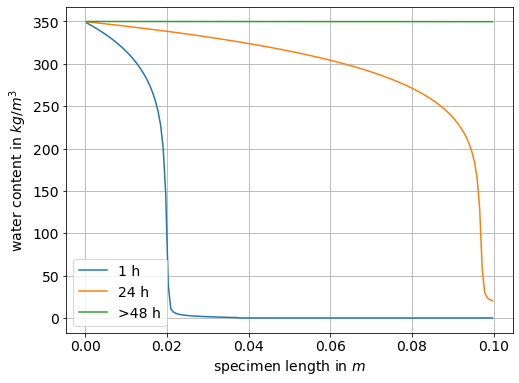

In [5]:
plt.plot(val_problem.x, val_sol.y[1:-1,1], label="1 h")
plt.plot(val_problem.x, val_sol.y[1:-1,24], label="24 h")
plt.plot(val_problem.x, val_sol.y[1:-1,48], label=">48 h")
plt.legend()
plt.grid()
plt.xlabel('specimen length in $m$')
plt.ylabel('water content in $kg/m^3$')
plt.show()

Comparing this with results from the literature shows that the results match.

```{figure} ./img/A4_imbibition.jpg
---
name: A4_imbibition-fig
width: 400px
align: left
---
Literature results of imbibition experiment show good agreement. (source: {cite}`A4`)
```


## Literature validation II: drying experiment
In the drying experiment the specimen starts with a certain moisture and is exposed to a room with a certain temperature and moisture (here we use $T=23°C$ and $\varphi=50%$). Liquid water will not be allowed to flow to the room, but vapor can diffuse. This situation will be modeled by creating a material cell, that has vapor pressure of that air. The diffusion coefficient for passing into the material cell is not quite the same as it would be for passing from the surface of the specimen into the room. This difference will be neglected here. 

The other side will be assumed to be air- and water-tight.

### Problem setup

In [6]:
# drying...
# ------------

# calculate P_suc and w for 23°C, 50%rH:
P_suc_west = opp.p_suc_kelvin_calc(0.5)


vval_problem = opp.one_d_problem(res=res_g, sim_time=100, material='AAC_A4_mod', init_w=0, length=.1, w_west=0, w_east=0)
w_sat = vval_problem.free_saturation
w_west = vval_problem.w_calc(P_suc_west) / w_sat
val_problem = opp.one_d_problem(res=res_g, sim_time=1000, material='AAC_A4_mod_dry', init_w=310/w_sat, length=.1, w_west=w_west, w_east=0)
# val_problem = opp.one_d_problem(res=30, sim_time=1000, material='AAC_A4_mod', init_w=310/350, length=.1, w_west=0, w_east=0)


val_problem.fluid_flow_west = False
val_problem.fluid_flow_east = False
val_problem.vapour_flow_west = True
val_problem.vapour_flow_east = False

val_problem.liquid_conduction = True
val_problem.vapour_diffusion = True

t0 = 0  # Start time in hours
tf = val_problem.sim_time  # End time in hours
t_eval = np.linspace(t0, tf, 1000)
w0 = val_problem.w[:]


### Solving

In [7]:
print('Calling scipy.integrate.slove_ivp() ...')
start_time = time.time()
val_sol = solve_ivp(val_problem.dwdt_calc, (t0, tf), w0, t_eval=t_eval, method='Radau',
                vectorized=False, dense_output=False, atol=1e-7, rtol=1e-5)
print(f'time elapsed: {(time.time() - start_time):.3f} s')

Calling scipy.integrate.slove_ivp() ...
time elapsed: 6.276 s


### Plotting

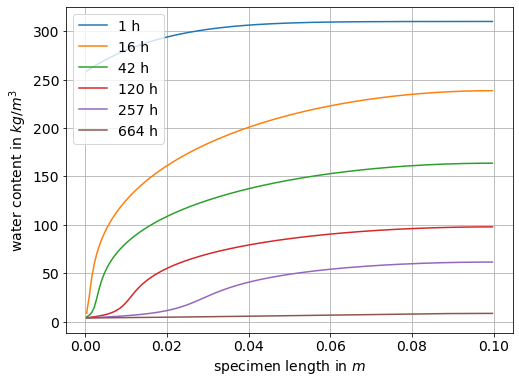

In [8]:
plt.plot(val_problem.x, val_sol.y[1:-1, 1], label="1 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 16], label="16 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 42], label="42 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 120], label="120 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 257], label="257 h")
plt.plot(val_problem.x, val_sol.y[1:-1, 664], label="664 h")
plt.legend()
plt.grid()
plt.xlabel('specimen length in $m$')
plt.ylabel('water content in $kg/m^3$')
plt.show()

Comparing this to the literature, we see that the results are in accordance with {cite}`A4`, if the starting point is considered to be the $80h$ mark in the figure below. The process before $80h$ is determined by a model describing porous material, that is moist beyond capillary saturation, which is out of scope of this project:

```{figure} ./img/A4_drying.jpg
---
name: A4_drying-fig
width: 400px
align: left
---
Literature results of drying experiment show good agreement. (source: {cite}`A4`)
```

## Conclusion
The implemented model neglects some physical phenomena:
* gravity
* vapor diffusion on the boundary of the domain is modelled as diffusion inside the material, even in the drying experiment, where it is actually surface diffusion of vapor.

The results are still satisfactory, since:
* Literature validation shows good agreement.
* The water intake coefficient is reproduced very accurately.
* The moving water front is reproduced.

